## Twitter + Watson Tone Analyzer Sample Notebook
In this sample notebook, we show how to load and analyze data from the Twitter + Watson Tone Analyzer Spark sample application (code can be found here https://github.com/ibm-cds-labs/spark.samples/tree/master/streaming-twitter). The tweets data has been enriched with scores from various Sentiment Tone (e.g Anger, Cheerfulness, etc...).

In [1]:
# Import SQLContext and data types
from pyspark.sql import SQLContext
from pyspark.sql.types import *

# sc is an existing SparkContext.
sqlContext = SQLContext(sc)

## Load the data
In this section, we load the data from a parquet file that has been saved from a scala notebook (see tutorial here...) and create a SparkSQL DataFrame that contains all the data.

In [2]:
parquetFile = sqlContext.parquetFile("swift://twitter2.spark/tweetsFull6.parquet")

In [3]:
parquetFile.registerAsTable("tweets");
sqlContext.cacheTable("tweets")
tweets = sqlContext.sql("SELECT * FROM tweets")
print tweets.count()
tweets.cache()

1363


DataFrame[author: string, date: string, lang: string, text: string, lat: double, long: double, Cheerfulness: double, Negative: double, Anger: double, Analytical: double, Confident: double, Tentative: double, Openness: double, Agreeableness: double, Conscientiousness: double]

## Compute the distribution of tweets by sentiments > 60%
In this section, we demonstrate how to use SparkSQL queries to compute for each tone that number of tweets that are greater than 60%

In [4]:
#create an array that will hold the count for each sentiment
sentimentDistribution=[0] * 9
#For each sentiment, run a sql query that counts the number of tweets for which the sentiment score is greater than 60%
#Store the data in the array
for i, sentiment in enumerate(tweets.columns[-9:]):
    sentimentDistribution[i]=sqlContext.sql("SELECT count(*) as sentCount FROM tweets where " + sentiment + " > 60").collect()[0].sentCount

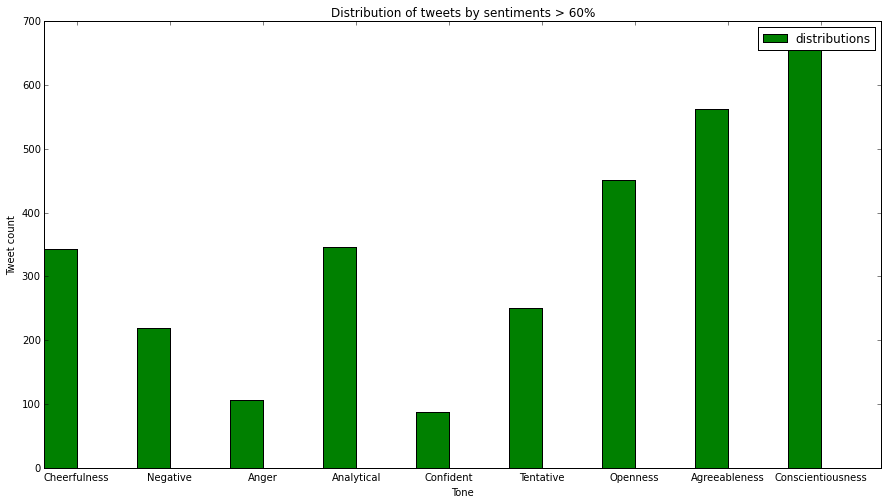

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind=np.arange(9)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.5, plSize[1]*2) )
plt.ylabel('Tweet count')
plt.xlabel('Tone')
plt.title('Distribution of tweets by sentiments > 60%')
plt.xticks(ind+width, tweets.columns[-9:])
plt.legend()

plt.show()

## Top 10 hashtags
In this section, we demonstrate how to use transformations on a SparkSQL DataFrame to compute the list of top 10 hashtags in all the tweets in the dataset

In [6]:
from operator import add
tagsRDD = tweets.flatMap( lambda t: t.text.split(' '))\
    .filter( lambda word: word.startswith("#") )\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

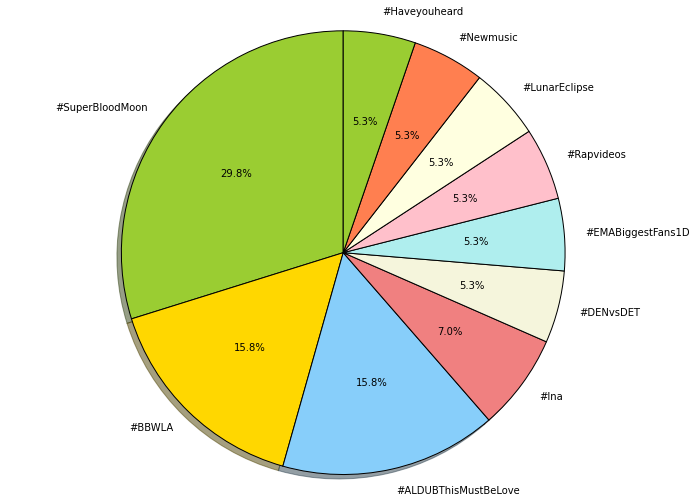

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

plt.show()

## Breakdown of the top 5 hashtags by sentiment scores
In this section, we demonstrate how to build a more complex analytic which decompose the top 5 hashtags by sentiment scores. The code below computes the mean of all the sentiment scores and visualize them in a multi-series bar chart

In [8]:
cols = tweets.columns[-9:]
def expand( t ):
    ret = []
    for s in [i[0] for i in top10tags]:
        if ( s in t.text ):
            for tone in cols:
                ret += [s + u"-" + unicode(tone) + ":" + unicode(getattr(t, tone))]
    return ret 
def makeList(l):
    return l if isinstance(l, list) else [l]

#Create RDD from tweets dataframe
tagsRDD = tweets.map(lambda t: t )

#Filter to only keep the entries that are in top10tags
tagsRDD = tagsRDD.filter( lambda t: any(s in t.text for s in [i[0] for i in top10tags] ) )

#Create a flatMap using the expand function defined above, this will be used to collect all the scores 
#for a particular tag with the following format: Tag-Tone-ToneScore
tagsRDD = tagsRDD.flatMap( expand )

#Create a map indexed by Tag-Tone keys 
tagsRDD = tagsRDD.map( lambda fullTag : (fullTag.split(":")[0], float( fullTag.split(":")[1]) ))

#Call combineByKey to format the data as follow
#Key=Tag-Tone
#Value=(count, sum_of_all_score_for_this_tone)
tagsRDD = tagsRDD.combineByKey((lambda x: (x,1)),
                  (lambda x, y: (x[0] + y, x[1] + 1)),
                  (lambda x, y: (x[0] + y[0], x[1] + y[1])))

#ReIndex the map to have the key be the Tag and value be (Tone, Average_score) tuple
#Key=Tag
#Value=(Tone, average_score)
tagsRDD = tagsRDD.map(lambda (key, ab): (key.split("-")[0], (key.split("-")[1], round(ab[0]/ab[1], 2))))

#Reduce the map on the Tag key, value becomes a list of (Tone,average_score) tuples
tagsRDD = tagsRDD.reduceByKey( lambda x, y : makeList(x) + makeList(y) )

#Sort the (Tone,average_score) tuples alphabetically by Tone
tagsRDD = tagsRDD.mapValues( lambda x : sorted(x) )

#Format the data as expected by the plotting code in the next cell. 
#map the Values to a tuple as follow: ([list of tone], [list of average score])
#e.g. #someTag:([u'Agreeableness', u'Analytical', u'Anger', u'Cheerfulness', u'Confident', u'Conscientiousness', u'Negative', u'Openness', u'Tentative'], [1.0, 0.0, 0.0, 1.0, 0.0, 0.48, 0.0, 0.02, 0.0])
tagsRDD = tagsRDD.mapValues( lambda x : ([elt[0] for elt in x],[elt[1] for elt in x])  )

#Use custom sort function to sort the entries by order of appearance in top10tags
def customCompare( key ):
    for (k,v) in top10tags:
        if k == key:
            return v
    return 0
tagsRDD = tagsRDD.sortByKey(ascending=False, numPartitions=None, keyfunc = customCompare)

#Take the mean tone scores for the top 10 tags
top10tagsMeanScores = tagsRDD.take(10)


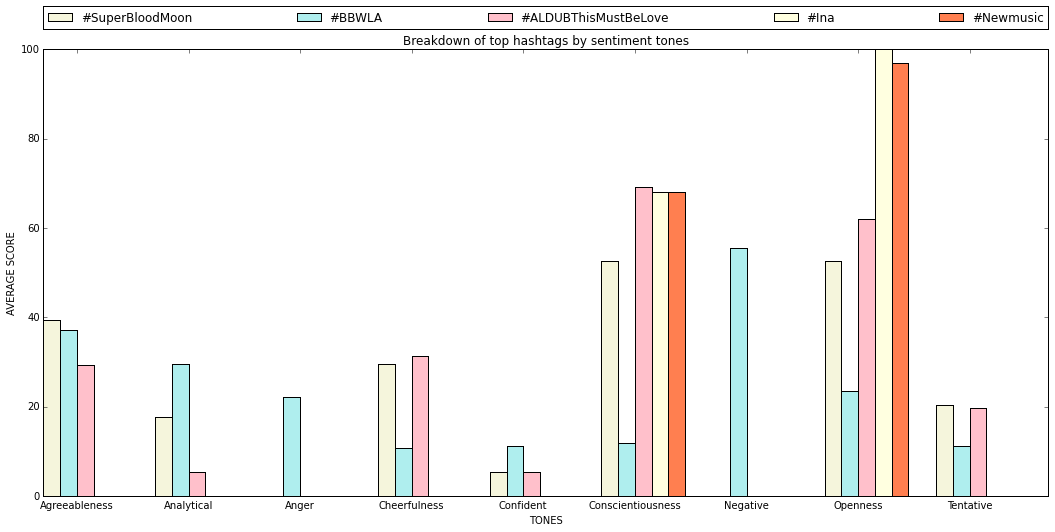

In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )

top5tagsMeanScores = top10tagsMeanScores[:5]
width = 0
ind=np.arange(9)
(a,b) = top5tagsMeanScores[0]
labels=b[0]
colors = ["beige", "paleturquoise", "pink", "lightyellow", "coral", "lightgreen", "gainsboro", "aquamarine","c"]
idx=0
for key, value in top5tagsMeanScores:
    plt.bar(ind + width, value[1], 0.15, color=colors[idx], label=key)
    width += 0.15
    idx += 1
plt.xticks(ind+0.3, labels)
plt.ylabel('AVERAGE SCORE')
plt.xlabel('TONES')
plt.title('Breakdown of top hashtags by sentiment tones')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',ncol=5, mode="expand", borderaxespad=0.)

plt.show()